In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from scipy.spatial import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [19]:
pm25_df = pd.read_csv("./Data/county_pm25.csv")
pm25_df = pm25_df.dropna()
pm25_df = pm25_df.groupby('fips', as_index=False).agg({'pm25' : 'mean'})
pm25_df

,fips,pm25
0,1001.0,11.712587
1,1003.0,10.077723
2,1005.0,10.981967
3,1007.0,11.998715
4,1009.0,11.793023
...,...,...
3092,56037.0,4.896375
3093,56039.0,3.867683
3094,56041.0,5.088060
3095,56043.0,5.025529


In [22]:
mortality_df = pd.read_csv("./Data/county_old_mortality.txt", sep='\t')
mortality_df['County'] = mortality_df['County'].apply(lambda x: x[-2:])
mortality_df

,County,County Code,Deaths,Population,Crude Rate
NaN,AL,1001,5338,109652,4868.1
NaN,AL,1003,22452,526184,4266.9
NaN,AL,1005,3675,71542,5136.8
NaN,AL,1007,2685,51438,5219.9
NaN,AL,1009,7076,146136,4842.1
...,...,...,...,...,...
NaN,WY,56037,2991,64222,4657.3
NaN,WY,56039,946,35161,2690.5
NaN,WY,56041,1408,32316,4357.0
NaN,WY,56043,1228,26285,4671.9


In [26]:
fips_df = pd.read_csv("./Data/NCHSURCodes2013.csv")
fips_df['State Abr.']

0       AL
1       AL
2       AL
3       AL
4       AL
        ..
3144    WY
3145    WY
3146    WY
3147    WY
3148    WY
Name: State Abr., Length: 3149, dtype: object

In [37]:
merged_df = fips_df.merge(mortality_df, left_on='State Abr.', right_on='County')
merged_df = merged_df.merge(pm25_df, left_on='FIPS', right_on='fips')

main_df = merged_df[['County', 'Deaths', 'Population', 'pm25']]
main_df = main_df.set_index('County')
main_df

,Deaths,Population,pm25
County,,,
AL,5338,109652,11.712587
AL,22452,526184,11.712587
AL,3675,71542,11.712587
AL,2685,51438,11.712587
AL,7076,146136,11.712587
...,...,...,...
WY,2991,64222,3.424542
WY,946,35161,3.424542
WY,1408,32316,3.424542


In [34]:
def PCA(df):
    # Standardizse the features
    df_norm = (df-df.mean())/df.std()
    print('Normalized data')
    #display(df_norm)


    # Apply PCA
    pca = decomposition.PCA(n_components=4)
    PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3', 'Component #4'])
    print("After PCA")
    print("Singular values:", pca.singular_values_)
    #display(PCA_df)


    # Append the target Label columns
    target = pd.Series(label , name='label')

    df = pd.concat([df, target], axis = 1)
    PCA_df = pd.concat([PCA_df, target], axis = 1)
    return PCA_df, pca

In [42]:
df = main_df
df_norm = (df-df.mean())/df.std()
pca = decomposition.PCA(n_components=3)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3'])
print("Singular values:", pca.singular_values_)

Singular values: [774.56612799 547.75312126  41.44673117]


,Deaths,Population,pm25
0,0.706561,0.706360,0.042735
1,0.025512,0.034924,-0.999064
2,-0.707192,0.706990,0.006655


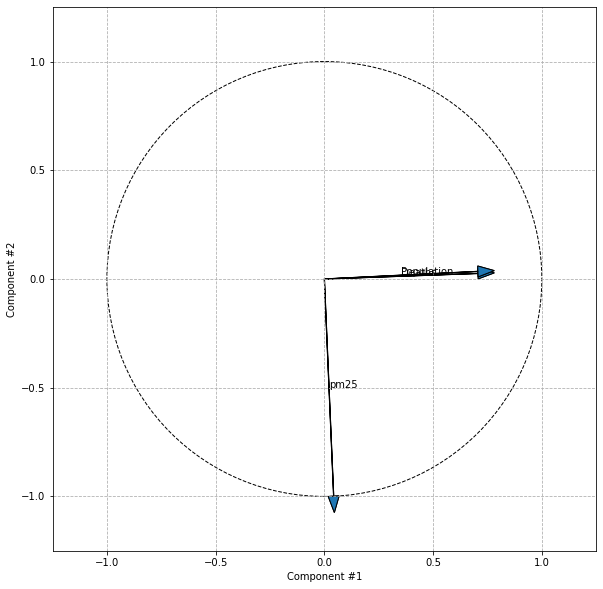

In [47]:
gla = pd.DataFrame(data=[[pca.components_[c,n] for n in range(pca.n_components_)] for c in range(pca.n_components_)],
             index=[0,1,2],
             columns = df_norm.columns)
display(gla)


# Plot 0 vs 1
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)

circle1 = plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False)
ax.add_artist(circle1)

for c in df_norm:
    ax.annotate(c, xy=(gla[c][0]/2, gla[c][1]/2))
    ax.add_artist(plt.arrow(0, 0, gla[c][0], gla[c][1], head_width=0.05))
    
ax.set_aspect(1)
plt.grid(linestyle='--')
plt.xlabel('Component #1')
plt.ylabel('Component #2')
plt.show()